<a href="https://colab.research.google.com/github/joeyave/machine-learning-project6/blob/main/machine_learning_project6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

titanic_file_path = '/content/drive/My Drive/Colab Notebooks/train-project2.csv'
titanic_data = pd.read_csv(titanic_file_path)
titanic_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,1.0,0.329064,0.333333,0.0,0.043975,1,0,1
1,1,0.0,0.573041,0.333333,0.0,0.432369,0,0,0
2,1,1.0,0.390058,0.000000,0.0,0.048069,0,0,1
3,1,0.0,0.527295,0.333333,0.0,0.322078,0,0,1
4,0,1.0,0.527295,0.000000,0.0,0.048827,1,0,1


In [ ]:
X = titanic_data[titanic_data.columns[1:]]
corr = X.corr()
corr

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
Pclass,1.000000,-0.327569,-0.054688,-0.080384,-0.689576,0.133391,0.219541,0.041145
Age,-0.327569,1.000000,-0.144907,-0.255949,0.149328,0.099758,-0.008819,-0.003522
SibSp,-0.054688,-0.144907,1.000000,0.306784,0.250832,-0.201663,-0.054833,0.005831
Parch,-0.080384,-0.255949,0.306784,1.000000,0.263038,-0.254059,-0.108576,0.020517
Fare,-0.689576,0.149328,0.250832,0.263038,1.000000,-0.239992,-0.139710,-0.129325
Sex_male,0.133391,0.099758,-0.201663,-0.254059,-0.239992,1.000000,-0.098772,0.136469
Embarked_Q,0.219541,-0.008819,-0.054833,-0.108576,-0.139710,-0.098772,1.000000,-0.502040
Embarked_S,0.041145,-0.003522,0.005831,0.020517,-0.129325,0.136469,-0.502040,1.000000


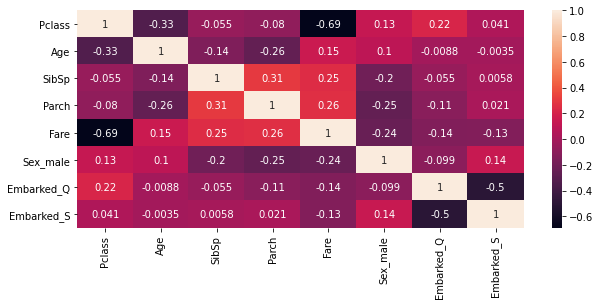

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
sns.heatmap(corr, annot=True)

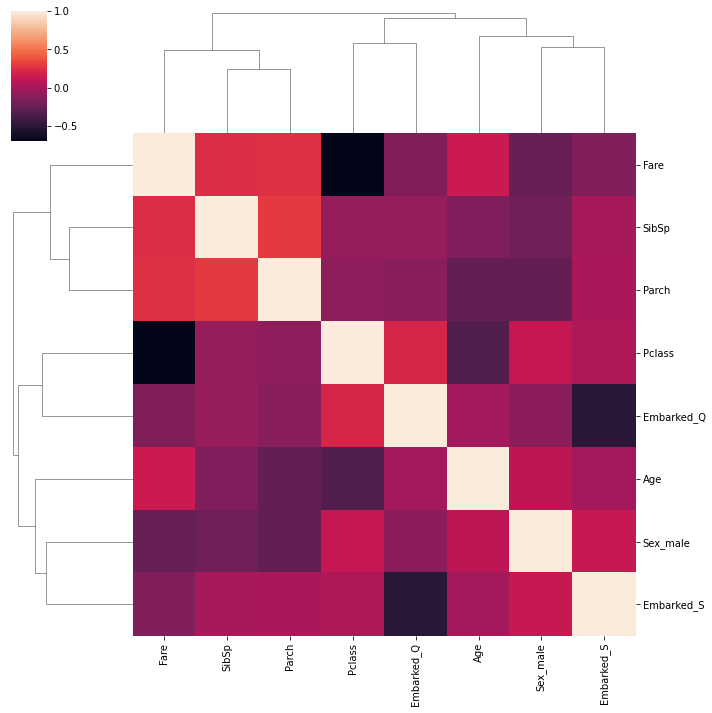

In [ ]:
sns.clustermap(corr)

In [ ]:
redundant_features = []

for i in range(corr.shape[0]):
    for k in range(corr.shape[1]):
        if k > i:
            if abs(corr.iloc[i, k]) >= 0.95:
                print(i, k, corr.iloc[i, k])
                redundant_features.append(X.columns[k])
                continue
redundant_features

[]

In [ ]:
filtered_titanic_data = titanic_data.drop(columns=redundant_features)
filtered_titanic_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,1.0,0.329064,0.333333,0.0,0.043975,1,0,1
1,1,0.0,0.573041,0.333333,0.0,0.432369,0,0,0
2,1,1.0,0.390058,0.000000,0.0,0.048069,0,0,1
3,1,0.0,0.527295,0.333333,0.0,0.322078,0,0,1
4,0,1.0,0.527295,0.000000,0.0,0.048827,1,0,1


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

y = titanic_data.Survived

model = KNeighborsClassifier()

train_X, val_X, train_y, val_y = train_test_split(X, y, shuffle=True)
model.fit(train_X, train_y)

train_predictions = model.predict(train_X)
print('before: ' + str(accuracy_score(train_y, train_predictions)))

X = filtered_titanic_data[filtered_titanic_data.columns[1:]]
train_X, val_X, train_y, val_y = train_test_split(X, y, shuffle=True)
model.fit(train_X, train_y)

train_predictions = model.predict(train_X)
print('after: ' + str(accuracy_score(train_y, train_predictions)))

before: 0.8580750407830342
after: 0.8760195758564437


In [ ]:
from sklearn.feature_selection import chi2
import numpy as np

chi2_stats = chi2(titanic_data, np.array(titanic_data.iloc[:, 0]))[0]
chi2_stats_table = pd.DataFrame({ 'column': titanic_data.columns[1:], 'chi2_stats': chi2_stats[1:] }) \
    .sort_values(by='chi2_stats', ascending=False)
chi2_stats_table

,column,chi2_stats
5,Sex_male,85.323417
0,Pclass,21.542741
3,Parch,21.073031
4,Fare,18.206226
7,Embarked_S,4.759596
2,SibSp,2.782164
1,Age,0.561675
6,Embarked_Q,0.340991


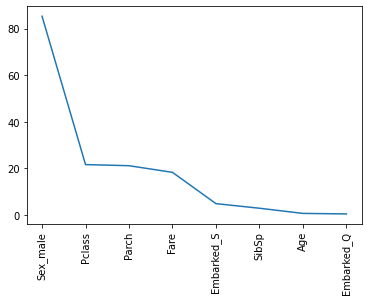

In [ ]:
plt.xticks(rotation='vertical')
plt.plot(chi2_stats_table['column'], chi2_stats_table['chi2_stats'])

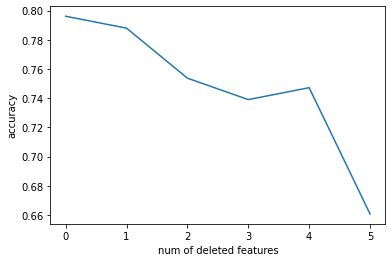

In [ ]:
def plot(model, stats_table):
    titanic_data_sorted = titanic_data[stats_table['column']]

    X = titanic_data_sorted[titanic_data_sorted.columns[1:]]
    y = titanic_data.Survived

    train_X, val_X, train_y, val_y = train_test_split(X, y, shuffle=True)
    model.fit(train_X, train_y)

    accuracy = {}
    for i in range(titanic_data_sorted.shape[1]):
        model.fit(X, y)
        accuracy[i] = accuracy_score(train_y, model.predict(train_X[X.columns])) 
        X = X.iloc[:,:len(X.columns)-1]
        
        if len(X.columns)-1 < 1:
            break

    plt.xlabel("num of deleted features")
    plt.ylabel("accuracy")
    plt.plot(list(accuracy.keys()), list(accuracy.values()))
    plt.show()

model = KNeighborsClassifier()
plot(model, chi2_stats_table)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

X = titanic_data[titanic_data.columns[1:]]
y = titanic_data.Survived

random_forest_model = RandomForestClassifier()
grid_search = GridSearchCV(random_forest_model, param_grid={'max_depth': range(1, 20)})
grid_search.fit(X, y)
max_depth = grid_search.best_params_['max_depth']
max_depth

11

In [ ]:
random_forest_model = RandomForestClassifier(max_depth=max_depth)
random_forest_model.fit(X, y)

random_forest_stats_table = pd.DataFrame({ 'column': titanic_data.columns[1:], 'random_forest_stats': random_forest_model.feature_importances_ }) \
    .sort_values(by='random_forest_stats', ascending=False)
random_forest_stats_table

,column,random_forest_stats
5,Sex_male,0.301073
4,Fare,0.261684
1,Age,0.233420
0,Pclass,0.084502
2,SibSp,0.044458
3,Parch,0.040206
7,Embarked_S,0.022507
6,Embarked_Q,0.012149


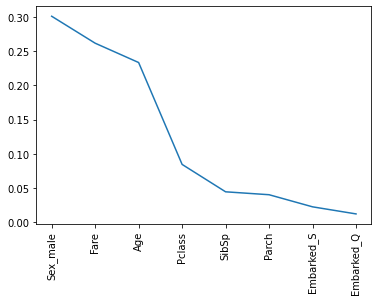

In [ ]:
plt.xticks(rotation='vertical')
plt.plot(random_forest_stats_table['column'], random_forest_stats_table['random_forest_stats'])

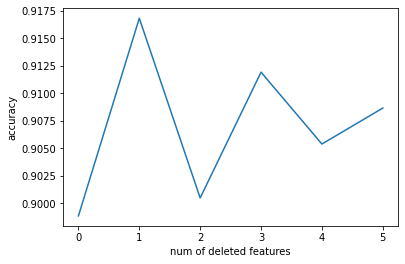

In [ ]:
plot(random_forest_model, random_forest_stats_table)

In [ ]:
X = titanic_data[titanic_data.columns[1:]]
y = titanic_data.Survived

train_X, val_X, train_y, val_y = train_test_split(X, y, shuffle=True)
random_forest_model.fit(train_X, train_y)

train_predictions = random_forest_model.predict(train_X)
print('before: ' + str(accuracy_score(train_y, train_predictions)))

filtered_titanic_data = titanic_data.drop(columns='Embarked_Q')
X = filtered_titanic_data[filtered_titanic_data.columns[1:]]
train_X, val_X, train_y, val_y = train_test_split(X, y, shuffle=True)
random_forest_model.fit(train_X, train_y)

train_predictions = random_forest_model.predict(train_X)
print('after: ' + str(accuracy_score(train_y, train_predictions)))

before: 0.9477977161500816
after: 0.9526916802610114
